In [32]:
import torch
import torch.nn as nn
import snntorch as snn
from snntorch.spikevision import spikedata
import tonic
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader
from tonic import DiskCachedDataset
# create datasets
import tonic.transforms as transforms
import snntorch.spikeplot as splt
import matplotlib.pyplot as plt
from tqdm import tqdm
sensor_size = tonic.datasets.NMNIST.sensor_size

# Denoise removes isolated, one-off events
# time_window
import torch
import torchvision
sensor_size = tonic.datasets.NMNIST.sensor_size


# Denoise removes isolated, one-off events
# time_window
frame_transform = transforms.Compose([transforms.Denoise(filter_time=10000),
                                      transforms.ToFrame(sensor_size=sensor_size,
                                                         time_window=1000)
                                     ])

trainset = tonic.datasets.NMNIST(save_to='./data', transform=frame_transform, train=True)
testset = tonic.datasets.NMNIST(save_to='./data', transform=frame_transform, train=False)
transform = tonic.transforms.Compose([torch.from_numpy,
                                      torchvision.transforms.RandomRotation([-10,10])])

cached_trainset = DiskCachedDataset(trainset, transform=transform, cache_path='./cache/nmnist/train')

# no augmentations for the testset
cached_testset = DiskCachedDataset(testset, cache_path='./cache/nmnist/test')

batch_size = 128
trainloader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)
testloader = DataLoader(cached_testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False))


NameError: name 'HTML' is not defined

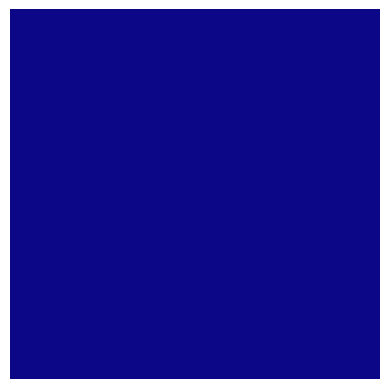

In [7]:
testdata,label  = trainset[0]
spike_data_sample = testdata[:,1,:,:]
spike_data_sample = torch.from_numpy(spike_data_sample).float()
#  Plot
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample, fig, ax)
anim.save("spike_mnist.gif")
HTML(anim.to_html5_video())

#  Save as a gif
anim.save("spike_mnist.gif")

In [17]:
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import spikeplot as splt
from snntorch import utils
import torch.nn as nn

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# neuron and simulation parameters
spike_grad = surrogate.atan()
beta1 = torch.rand(1, device=device)
beta2 = torch.rand(1, device=device)
beta3 = torch.rand(1, device=device)
#  Initialize Network
net = nn.Sequential(nn.Conv2d(2, 12, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta1, spike_grad=spike_grad, init_hidden=True,learn_beta=beta1),
                    nn.Conv2d(12, 32, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta2, spike_grad=spike_grad, init_hidden=True,learn_beta=beta2),
                    nn.Flatten(),
                    nn.Linear(32*5*5, 10),
                    snn.Leaky(beta=beta3, spike_grad=spike_grad, init_hidden=True,learn_beta=beta3, output=True)
                    ).to(device)
# this time, we won't return membrane as we don't need it

def forward_pass(net, data):
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(data.size(0)):  # data.size(0) = number of time steps
      spk_out, mem_out = net(data[step])
      spk_rec.append(spk_out)

  return torch.stack(spk_rec)

In [6]:
optimizer = torch.optim.Adam(net.parameters(), lr=2e-2, betas=(0.9, 0.999))
#loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)
loss_fn = SF.ce_count_loss()

In [11]:
for i, (data, targets) in enumerate(iter(trainloader)):
    print(data.shape)

torch.Size([311, 128, 2, 34, 34])
torch.Size([312, 128, 2, 34, 34])
torch.Size([312, 128, 2, 34, 34])
torch.Size([311, 128, 2, 34, 34])
torch.Size([311, 128, 2, 34, 34])
torch.Size([313, 128, 2, 34, 34])
torch.Size([309, 128, 2, 34, 34])
torch.Size([310, 128, 2, 34, 34])
torch.Size([311, 128, 2, 34, 34])
torch.Size([311, 128, 2, 34, 34])
torch.Size([310, 128, 2, 34, 34])
torch.Size([311, 128, 2, 34, 34])
torch.Size([311, 128, 2, 34, 34])
torch.Size([310, 128, 2, 34, 34])
torch.Size([312, 128, 2, 34, 34])


KeyboardInterrupt: 

In [7]:
num_epochs = 1
num_iters = 100

loss_hist = []
acc_hist = []

# training loop
for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(iter(trainloader)):
        data = data.to(device)
        targets = targets.to(device)

        net.train()
        spk_rec = forward_pass(net, data)
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")

        acc = SF.accuracy_rate(spk_rec, targets)
        acc_hist.append(acc)
        print(f"Accuracy: {acc * 100:.2f}%\n")

        # training loop breaks after 50 iterations
        if i == num_iters:
          break

Epoch 0, Iteration 0 
Train Loss: 2.30
Accuracy: 4.69%

Epoch 0, Iteration 1 
Train Loss: 2.30
Accuracy: 9.38%

Epoch 0, Iteration 2 
Train Loss: 2.33
Accuracy: 14.06%

Epoch 0, Iteration 3 
Train Loss: 2.31
Accuracy: 10.16%

Epoch 0, Iteration 4 
Train Loss: 3.50
Accuracy: 19.53%

Epoch 0, Iteration 5 
Train Loss: 2.30
Accuracy: 7.03%

Epoch 0, Iteration 6 
Train Loss: 2.30
Accuracy: 6.25%

Epoch 0, Iteration 7 
Train Loss: 2.30
Accuracy: 6.25%

Epoch 0, Iteration 8 
Train Loss: 2.30
Accuracy: 7.03%

Epoch 0, Iteration 9 
Train Loss: 2.30
Accuracy: 6.25%

Epoch 0, Iteration 10 
Train Loss: 2.30
Accuracy: 13.28%

Epoch 0, Iteration 11 
Train Loss: 2.30
Accuracy: 13.28%

Epoch 0, Iteration 12 
Train Loss: 2.30
Accuracy: 13.28%

Epoch 0, Iteration 13 
Train Loss: 2.30
Accuracy: 6.25%

Epoch 0, Iteration 14 
Train Loss: 2.30
Accuracy: 11.72%



KeyboardInterrupt: 

In [18]:
import os
import glob
import zipfile
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

import IPython.display as display
from matplotlib import animation
Height = 720
Width = 1280
df_f = 2
roix =[int(0.67*Width)//df_f,int(0.70*Width)//df_f]
roiy = [int(0*Height)//df_f,int(1*Height)//df_f]

width = roix[1]-roix[0]
height = roiy[1] - roiy[0]

heightoffset = roiy[0]
widthoffset = roix[0]

In [19]:
# path setting
Dataset_path = '../data/'
pathlist = [f'{Dataset_path}numpysp2/3um_15uL_-25bias_-25off_25fo_lux+2/',
            f'{Dataset_path}numpysp2/8um_2000D_10uL_50to10min/',
            f'{Dataset_path}numpysp2/15um_10uL_50to10min/']

In [29]:
def tensor_fill(pathlist):
    for datapath in pathlist:
        npylist = glob.glob(f'{datapath}*.npy')
        filtered_npylist = [f for f in npylist if not os.path.basename(f).startswith('xypt')]
        filtered_npylist = [f for f in filtered_npylist if not os.path.basename(f).startswith('tpxy')]
        for idx,name in enumerate(filtered_npylist):
            data = np.load(name)
            temp = np.zeros((200,2,20,360),dtype=np.float32)
            mintime = min(data['t'])
            for i in range(len(data)):
                t = data[i]['t']-mintime
                p = data[i]['p']
                x = data[i]['x']-widthoffset
                y = data[i]['y']-heightoffset
                temp[t][p][x][y] = 1
            dirname, filename = os.path.split(name)
            new_filename = f'tpxy_filled_{filename}'
            new_filepath = os.path.join(dirname, new_filename)
            np.save(new_filepath, temp)            

In [30]:
#first time only
tensor_fill(pathlist)

In [12]:
datt = np.load('../data/numpysp2/8um_2000D_10uL_50to10min/tpxy_filled_101318400us.npy')
testensor = torch.from_numpy(datt).float()
print(testensor.shape)

torch.Size([200, 2, 20, 360])


In [21]:
# Dataset for SNN
class FCDataset(Dataset):
    '''
        pathlist: list of path to the classes
        sampling_time: total duration of the event file
        sample_bins: number of bins to sample the event file
        x: width of the sensor
        y: height of the sensor
    '''
    def __init__(
        self, pathlist=[],
        sampling_time=0.5e-6, sample_bins=100,x=128,y=128):
            super(FCDataset, self).__init__()
            self.classnum = len(pathlist)
            self.pathlist = pathlist
            self.sampling_time = sampling_time
            self.sample_bins = sample_bins
            self.data = []
            self.label = []
            self.x = x
            self.y = y
            for idx, path in enumerate(pathlist):
                eventflielist = glob.glob(f'{path}/tpxy_filled_*.npy')
                for eventfile in eventflielist:
                    event = np.load(eventfile)
                    self.data.append(event)
                    self.label.append(idx)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
            event = self.data[idx]
            spike = torch.from_numpy(event).float()
            label = self.label[idx]
            return spike, label

In [26]:
from snntorch import surrogate

# Define Network
class Net(nn.Module):
    def __init__(self,num_inputs, num_hidden, num_outputs, beta=0.9):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []
        #print(x.flatten(2).size())
        # time-loop
        x = x.transpose(0,1)
        for step in range(x.size(0)):
          cur1 = self.fc1(x[step].flatten(1)) # batch128 x 784
          spk1, mem1 = self.lif1(cur1, mem1)
          cur2 = self.fc2(spk1)
          spk2, mem2 = self.lif2(cur2, mem2)
          # store in list
          spk2_rec.append(spk2)
          mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0) # time-steps x batch x num_out

In [23]:
full_dataset = FCDataset(pathlist=pathlist)
from torch.utils.data import DataLoader, random_split

# 定义数据集大小的比例
train_size = int(0.8 * len(full_dataset))  # 假设训练集占80%
test_size = len(full_dataset) - train_size  # 剩余的为测试集
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

NameError: name 'HTML' is not defined

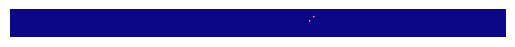

In [15]:


#  spike_data contains 128 samples, each of 100 time steps in duration

#  Index into a single sample from a minibatch
#spike_data_sample,label = train_dataset[0]
spike_data_sample = testensor[:,1,:,:]
#  Plot
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample, fig, ax)
anim.save("spike_mnist.gif")
HTML(anim.to_html5_video())

#  Save as a gif
anim.save("spike_mnist.gif")

In [24]:

def measure_accuracy(model, dataloader):
  with torch.no_grad():
    model.eval()
    running_length = 0
    running_accuracy = 0

    for data, targets in iter(dataloader):
      data = data.to(device)
      targets = targets.to(device)

      # forward-pass
      spk_rec, _ = model(data)
      spike_count = spk_rec.sum(0) # batch x num_outputs
      _, max_spike = spike_count.max(1)

      # correct classes for one batch
      num_correct = (max_spike == targets).sum()

      # total accuracy
      running_length += len(targets)
      running_accuracy += num_correct
    
    accuracy = (running_accuracy / running_length)

    return accuracy.item()
  

In [9]:
import gc
del net
gc.collect()

NameError: name 'net' is not defined

In [35]:
net = Net(num_inputs=20*360*2,num_hidden=1024,num_outputs=3).to(device)
loss = SF.ce_count_loss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-3, betas=(0.9, 0.999))
num_epochs = 100 # 60000 / 128 = 468
counter = 0
train_loader = DataLoader(train_dataset, batch_size=128,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128,shuffle=False)
# Outer training loop
for epoch in tqdm(range(num_epochs), desc='Epochs'):
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in tqdm(train_batch, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False):
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, _ = net(data)

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=torch.float32, device=device)
        loss_val += loss(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        # Print train/test loss/accuracy
        if counter % 10 == 0:
            print(f"Iteration: {counter} \t Train Loss: {loss_val.item()}")
            print(f"Test set accuracy: {measure_accuracy(net, test_loader)}")
        counter += 1

        if counter == 100:
          break

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration: 0 	 Train Loss: 1.0986120700836182


Test set accuracy: 0.3161450922489166


Iteration: 10 	 Train Loss: 0.5171931982040405


Test set accuracy: 0.787695586681366


Iteration: 20 	 Train Loss: 0.19254933297634125


Test set accuracy: 0.9196301698684692


Iteration: 30 	 Train Loss: 0.09450438618659973


Test set accuracy: 0.9157183170318604


Iteration: 40 	 Train Loss: 0.035640962421894073


Test set accuracy: 0.9672830700874329


Iteration: 50 	 Train Loss: 0.045064687728881836


Test set accuracy: 0.9807965755462646


Iteration: 60 	 Train Loss: 0.03687649220228195


Test set accuracy: 0.9879089593887329


Iteration: 70 	 Train Loss: 0.04903246462345123


Test set accuracy: 0.9900426864624023


Iteration: 80 	 Train Loss: 0.05040236935019493


Test set accuracy: 0.9903982877731323


Epochs:   1%|          | 1/100 [32:46<54:04:51, 1966.59s/it]

Iteration: 90 	 Train Loss: 0.00737003143876791


Test set accuracy: 0.9900426864624023


Epochs:   2%|▏         | 2/100 [37:57<27:01:27, 992.73s/it] 

Iteration: 100 	 Train Loss: 0.017157284542918205


Test set accuracy: 0.9871976971626282


Iteration: 110 	 Train Loss: 0.11571075767278671


Test set accuracy: 0.9889758229255676


Iteration: 120 	 Train Loss: 0.0022140289656817913


Test set accuracy: 0.9935988783836365


Iteration: 130 	 Train Loss: 0.014317741617560387


Test set accuracy: 0.9928876161575317


Iteration: 140 	 Train Loss: 0.04285320267081261


Test set accuracy: 0.9943100810050964


Iteration: 150 	 Train Loss: 0.008871879428625107


Test set accuracy: 0.9932432174682617


Iteration: 160 	 Train Loss: 0.02745836041867733


Test set accuracy: 0.9939544796943665


Iteration: 170 	 Train Loss: 0.0003425721370149404


Test set accuracy: 0.9928876161575317


Iteration: 180 	 Train Loss: 0.0006199583294801414


Epochs:   2%|▏         | 2/100 [1:20:26<65:41:34, 2413.20s/it]


KeyboardInterrupt: 